# **Load dataset**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"

In [4]:
%cd /content/drive/MyDrive/Kaggle/

/content/drive/MyDrive/Kaggle


In [5]:
!kaggle datasets download -d surajjha101/bigbasket-entire-product-list-28k-datapoints

bigbasket-entire-product-list-28k-datapoints.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip bigbasket-entire-product-list-28k-datapoints.zip

Archive:  bigbasket-entire-product-list-28k-datapoints.zip
  inflating: BigBasket Products.csv  


# **Import libraries**

In [6]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as px

from time import time
from datetime import datetime

from sklearn.model_selection import train_test_split


import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

In [7]:
raw_data = pd.read_csv("/content/drive/MyDrive/Kaggle/BigBasket Products.csv")
raw_data.head()

,index,product,category,sub_category,brand,sale_price,market_price,type,rating,description
0,1,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.0,220.0,Hair Oil & Serum,4.1,This Product contains Garlic Oil that is known...
1,2,Water Bottle - Orange,"Kitchen, Garden & Pets",Storage & Accessories,Mastercook,180.0,180.0,Water & Fridge Bottles,2.3,"Each product is microwave safe (without lid), ..."
2,3,"Brass Angle Deep - Plain, No.2",Cleaning & Household,Pooja Needs,Trm,119.0,250.0,Lamp & Lamp Oil,3.4,"A perfect gift for all occasions, be it your m..."
3,4,Cereal Flip Lid Container/Storage Jar - Assort...,Cleaning & Household,Bins & Bathroom Ware,Nakoda,149.0,176.0,"Laundry, Storage Baskets",3.7,Multipurpose container with an attractive desi...
4,5,Creme Soft Soap - For Hands & Body,Beauty & Hygiene,Bath & Hand Wash,Nivea,162.0,162.0,Bathing Bars & Soaps,4.4,Nivea Creme Soft Soap gives your skin the best...


# EDA and feature engineering

In [9]:
df = raw_data.copy(deep = True)

In [10]:
# Get the shape and size of the dataset
print('Shape of dataset:',df.shape)

Shape of dataset: (27555, 10)


In [ ]:
# Get more info on it
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27555 entries, 0 to 27554
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         27555 non-null  int64  
 1   product       27554 non-null  object 
 2   category      27555 non-null  object 
 3   sub_category  27555 non-null  object 
 4   brand         27554 non-null  object 
 5   sale_price    27555 non-null  float64
 6   market_price  27555 non-null  float64
 7   type          27555 non-null  object 
 8   rating        18929 non-null  float64
 9   description   27440 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 2.1+ MB


In [ ]:
# Get more statistic info on it
df.describe()

,index,sale_price,market_price,rating
count,27555.00000,27555.000000,27555.000000,18929.000000
mean,13778.00000,322.514808,382.056664,3.943410
std,7954.58767,486.263116,581.730717,0.739063
min,1.00000,2.450000,3.000000,1.000000
25%,6889.50000,95.000000,100.000000,3.700000
50%,13778.00000,190.000000,220.000000,4.100000
75%,20666.50000,359.000000,425.000000,4.300000
max,27555.00000,12500.000000,12500.000000,5.000000


In [ ]:
# Check for any Null values in the dataset
df.isna().sum()

index              0
product            1
category           0
sub_category       0
brand              1
sale_price         0
market_price       0
type               0
rating          8626
description      115
dtype: int64

In [ ]:
# Columns with missing values
na_cols=df.columns[df.isna().any()].tolist()

# Missing values summary
mv=pd.DataFrame(df[na_cols].isna().sum().sort_values(ascending=False), columns=['Number_missing'])
mv['Percentage_missing']=np.round(100*mv['Number_missing']/len(df),2)
mv

,Number_missing,Percentage_missing
rating,8626,31.30
description,115,0.42
product,1,0.00
brand,1,0.00


In [12]:
#let's drop the null values
df = df.dropna()

In [13]:
df.shape

(18840, 10)

So even after dropping null data, 18000+ products are available for recommendation.

In [14]:
df.drop('index', axis=1,inplace = True)
df.head()

,product,category,sub_category,brand,sale_price,market_price,type,rating,description
0,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.0,220.0,Hair Oil & Serum,4.1,This Product contains Garlic Oil that is known...
1,Water Bottle - Orange,"Kitchen, Garden & Pets",Storage & Accessories,Mastercook,180.0,180.0,Water & Fridge Bottles,2.3,"Each product is microwave safe (without lid), ..."
2,"Brass Angle Deep - Plain, No.2",Cleaning & Household,Pooja Needs,Trm,119.0,250.0,Lamp & Lamp Oil,3.4,"A perfect gift for all occasions, be it your m..."
3,Cereal Flip Lid Container/Storage Jar - Assort...,Cleaning & Household,Bins & Bathroom Ware,Nakoda,149.0,176.0,"Laundry, Storage Baskets",3.7,Multipurpose container with an attractive desi...
4,Creme Soft Soap - For Hands & Body,Beauty & Hygiene,Bath & Hand Wash,Nivea,162.0,162.0,Bathing Bars & Soaps,4.4,Nivea Creme Soft Soap gives your skin the best...


In [ ]:
df.nunique()

product         16217
category            9
sub_category       77
brand            1933
sale_price       2445
market_price     1005
type              358
rating             40
description     15300
dtype: int64

In [ ]:
df['category'].unique()

array(['Beauty & Hygiene', 'Kitchen, Garden & Pets',
       'Cleaning & Household', 'Gourmet & World Food',
       'Foodgrains, Oil & Masala', 'Snacks & Branded Foods', 'Beverages',
       'Bakery, Cakes & Dairy', 'Baby Care'], dtype=object)

<Axes: xlabel='count', ylabel='category'>

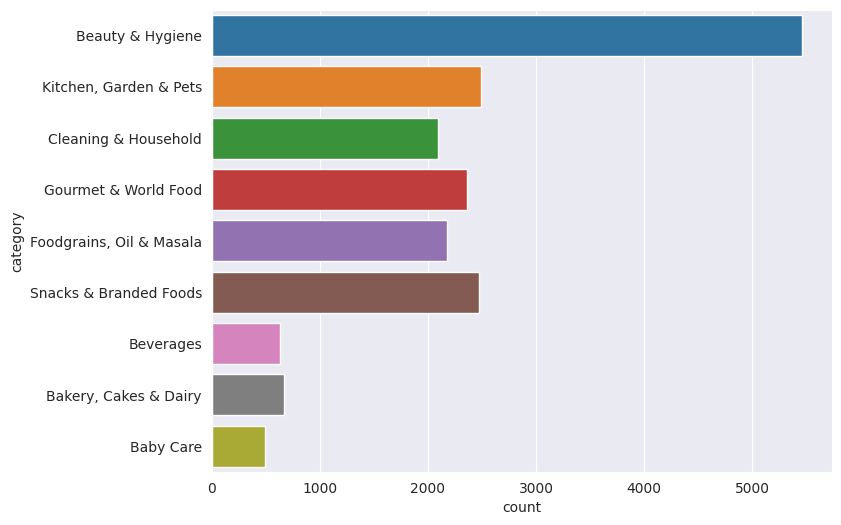

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(data = df, y = 'category')

In [ ]:
df['sub_category'].value_counts()

Skin Care                1641
Hair Care                 818
Bath & Hand Wash          808
Masalas & Spices          764
Storage & Accessories     658
                         ... 
Bakery Snacks              24
Mothers & Maternity        23
Water                      16
Gourmet Breads             10
Cuts & Sprouts              1
Name: sub_category, Length: 77, dtype: int64

In [ ]:
df['brand'].value_counts()

bb Royal     278
BB Home      172
Amul         153
Himalaya     139
Cello        104
            ... 
Fazlani        1
Fakira         1
Sofia          1
Dr. Schar      1
4700BC         1
Name: brand, Length: 1933, dtype: int64

In [ ]:
df['type'].value_counts()

Face Care                 1094
Men's Deodorants           404
Shampoo & Conditioner      390
Blended Masalas            343
Containers Sets            332
                          ... 
Health Supplements           1
Bagels & Baguette            1
Gift Wraps & Bags            1
Gourmet Tea & Tea Bags       1
Gourmet Popcorn              1
Name: type, Length: 358, dtype: int64

In [15]:
df.duplicated().sum()

190

In [16]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [17]:
df.shape

(18650, 9)

In [ ]:
count_product=df.groupby(['category','sub_category']).product.count().to_frame('Total_Products')
count_product

Total_Products
category               sub_category                             
Baby Care              Atta, Flours & Sooji                    1
                       Baby Accessories                       27
                       Baby Bath & Hygiene                   166
                       Baby Food & Formula                    44
                       Diapers & Wipes                       199
...                                                          ...
Snacks & Branded Foods Noodle, Pasta, Vermicelli             102
                       Pickles & Chutney                     149
                       Ready To Cook & Eat                   554
                       Snacks & Namkeen                      442
                       Spreads, Sauces, Ketchup              265

[82 rows x 1 columns]

In [ ]:
# Top 10 Highest and Lowest Sale Price Products
price_data=df[['product','brand','type','sale_price']]
highest_price=price_data.sort_values('sale_price',ascending=False)[:10]
lowest_price=price_data.sort_values('sale_price')[:10]

In [ ]:
highest_price

,product,brand,type,sale_price
1766,Good Girl Eau De Parfum For Women,Carolina Herrera,Eau De Parfum,6660.0
12192,Man In Black Eau De Parfum,Bvlgari,Eau De Parfum,6100.0
21637,"Casserole Set - Die-Cast, Induction Base, Granite",Wonderchef,Cookware Sets,6000.0
13962,Black Edition Eau De Parfum For Men,Bentley,Eau De Parfum,5940.0
17767,Eau De Toilette For Men,Bentley,Eau De Toilette,4905.0
13559,"Dog Food - Super Premium, Focus, Puppy, Limite...",Drools,Pet Meals & Treats,4675.0
3893,Naturally Pure Olive Oil,Fragata,"Pure, Pomace Olive Oil",4600.0
27538,Quista Pro Advanced Whey Protein Formula forti...,Himalaya,Supplements & Proteins,4500.0
2365,Pro Expert Nutrition Large Breed Puppy (3-18 M...,Pedigree,Pet Meals & Treats,4480.0
6451,Extra Virgin Olive Oil,Pietro Coricelli,Extra Virgin Olive Oil,4400.0


In [ ]:
lowest_price

,product,brand,type,sale_price
21312,Serum,Livon,Hair Oil & Serum,3.0
26584,Polo - The Mint With The Hole,Nestle,"Toffee, Candy & Lollypop",5.0
21228,Dish Shine Bar,Exo,Dishwash Bars & Powders,5.0
17943,Fulltoss Tangy Tomato,Parle,Nachos & Chips,5.0
14538,Cadbury Perk - Chocolate Bar,Cadbury,Chocolates,5.0
22178,Tiger Elaichi Cream Biscuits,Britannia,Glucose & Milk Biscuits,5.0
19202,Bounce Biscuits - Choco Creme,Sunfeast,Cream Biscuits & Wafers,5.0
16551,Biscuits - Magix Kreams Choc,Parle,Cream Biscuits & Wafers,5.0
15926,Dreams Cup Cake - Choco,Elite,Muffins & Cup Cakes,5.0
11306,Happy Happy Choco-Chip Cookies,Parle,Glucose & Milk Biscuits,5.0


In [ ]:
# Top rated products
top_rated=df[df.rating>=4.5]
product_top=top_rated[['brand','product','type','rating']].sort_values('rating',ascending=False)
product_top

,brand,product,type,rating
12,Oxy,"Face Wash - Oil Control, Active",Face Care,5.0
14555,INATUR,Argan Oil Shampoo,Shampoo & Conditioner,5.0
14736,Floh,Tampons - Regular,Tampons & Menstrual Cups,5.0
14734,Jivika Naturals,Natural Jaggery Granules,Exotic Sugar & Salt,5.0
14729,Himalaya,Extra Moisturizing Baby Soap,Baby Bath,5.0
...,...,...,...,...
21352,Nyassa,Rose & Lychee Soap,Bathing Bars & Soaps,4.5
15680,Fogg,Master Body Spray - Cedar,Men's Deodorants,4.5
13682,Morpheme Remedies,Castor Carrier Oil - Pure Coldpressed Oil,Aromatherapy,4.5
7123,Cello,Glass Water Bottle - Aquaria Organic Pink,Water & Fridge Bottles,4.5


In [ ]:
# Visualisation of number of products based on brand
brand_prod=df.brand.value_counts()
brand_prod

bb Royal     278
BB Home      172
Amul         153
Himalaya     139
BIOTIQUE     102
            ... 
Fakira         1
Sofia          1
Dr. Schar      1
Pledge         1
4700BC         1
Name: brand, Length: 1933, dtype: int64

In [ ]:
online_df=df.groupby('brand').size().reset_index().sort_values(0,ascending=False)
online_df.rename(columns={0:'count'},inplace=True)
online_df.head(3)

,brand,count
1919,bb Royal,278
138,BB Home,172
78,Amul,153


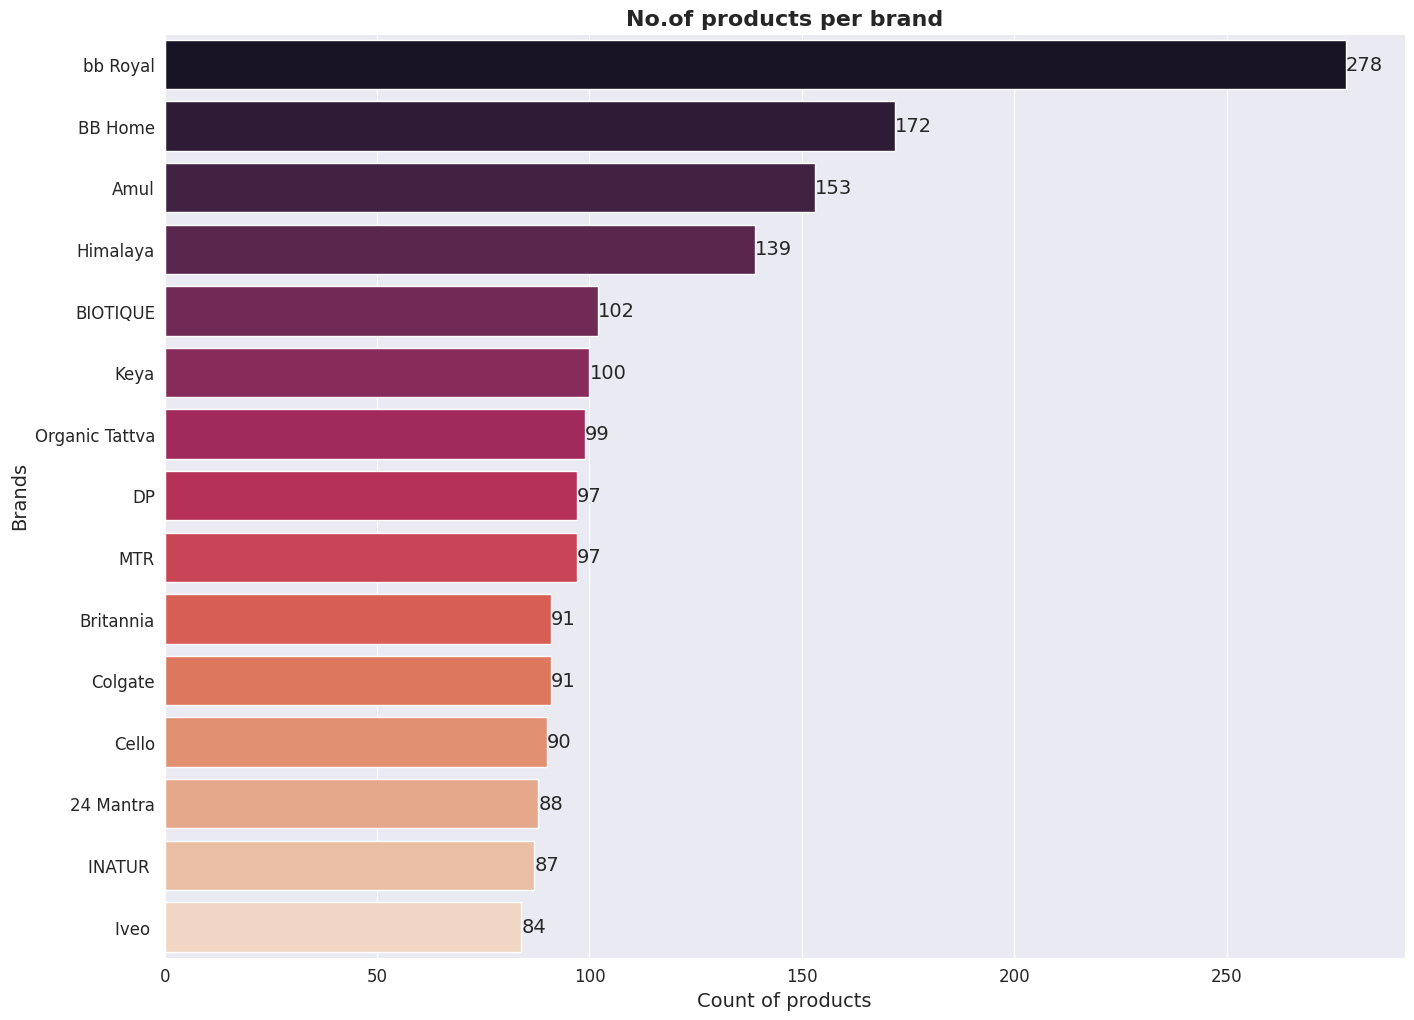

In [ ]:
plt.figure(figsize=(16,12))
kl=sns.barplot(data=online_df[:15],x='count',y='brand',palette='rocket')
kl.bar_label(kl.containers[0],fontsize=14)
plt.xlabel("Count of products",fontsize=14)
plt.ylabel("Brands",fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("No.of products per brand",fontsize=16,fontweight='bold')
plt.savefig('Brand --- Count of products in brand.jpg')
plt.show()

In [ ]:
# Visualisation of number of products based on category
product_category=df.groupby(['category']).size().reset_index().sort_values(0,ascending=False)
product_category.rename(columns={0:'count_prod'},inplace=True)
product_category[:3]

,category,count_prod
2,Beauty & Hygiene,5352
8,Snacks & Branded Foods,2464
7,"Kitchen, Garden & Pets",2442


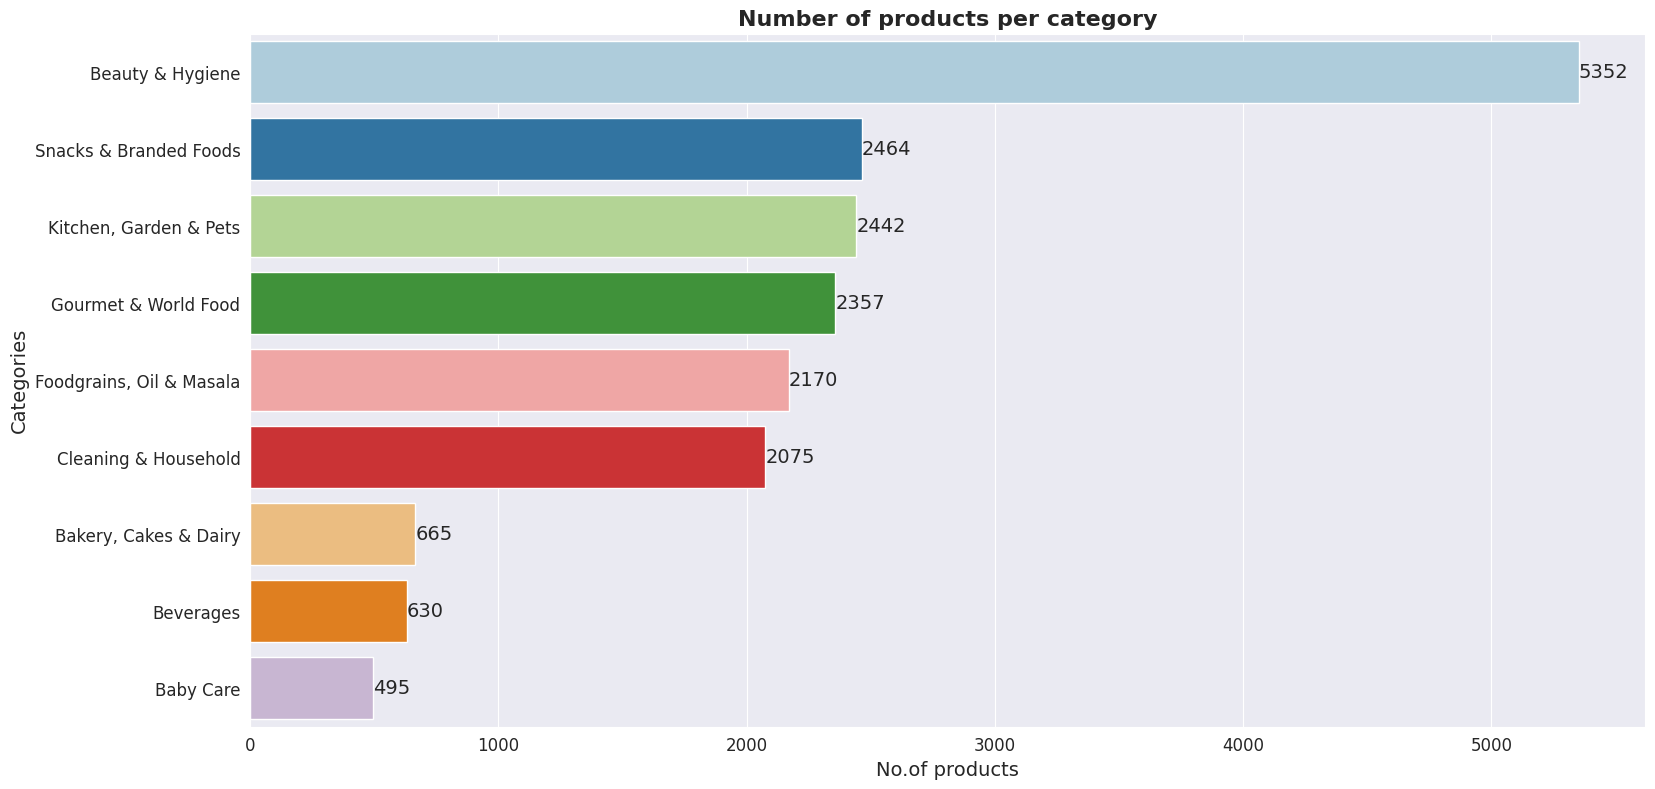

In [ ]:
plt.figure(figsize=(18,9))
ax=sns.barplot(data=product_category,x='count_prod',y='category',palette='Paired')
ax.bar_label(ax.containers[0],fontsize=14)
plt.xlabel("No.of products",fontsize=14)
plt.ylabel("Categories",fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Number of products per category",fontsize=16,fontweight='bold')
plt.savefig('categories vs no ofproducts.jpg')
plt.show()

In [ ]:
cat=list(df.category.unique())
cat[:5]

['Beauty & Hygiene',
 'Kitchen, Garden & Pets',
 'Cleaning & Household',
 'Gourmet & World Food',
 'Foodgrains, Oil & Masala']

In [ ]:
count_type=df.groupby(['category','sub_category']).type.count().to_frame('type_count')
cat_subcat=count_type.sort_values(['category','type_count'],ascending=False).reset_index()
cat_subcat

,category,sub_category,type_count
0,Snacks & Branded Foods,Ready To Cook & Eat,554
1,Snacks & Branded Foods,Snacks & Namkeen,442
2,Snacks & Branded Foods,Biscuits & Cookies,277
3,Snacks & Branded Foods,"Spreads, Sauces, Ketchup",265
4,Snacks & Branded Foods,Chocolates & Candies,257
...,...,...,...
77,Baby Care,Baby Food & Formula,44
78,Baby Care,Feeding & Nursing,41
79,Baby Care,Baby Accessories,27
80,Baby Care,Mothers & Maternity,17


In [ ]:
# Visualisation of top 5 category with sub category product count
for i in cat[:5]:
    labels_subcat=cat_subcat[cat_subcat['category']==i].sub_category.tolist()
    values_subcat=cat_subcat[cat_subcat['category']==i].type_count.tolist()
    plt.figure(figsize=(16,8))
    hui=px.pie(names=labels_subcat,values=values_subcat,hole=0.4,title=i)
    hui.show()

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

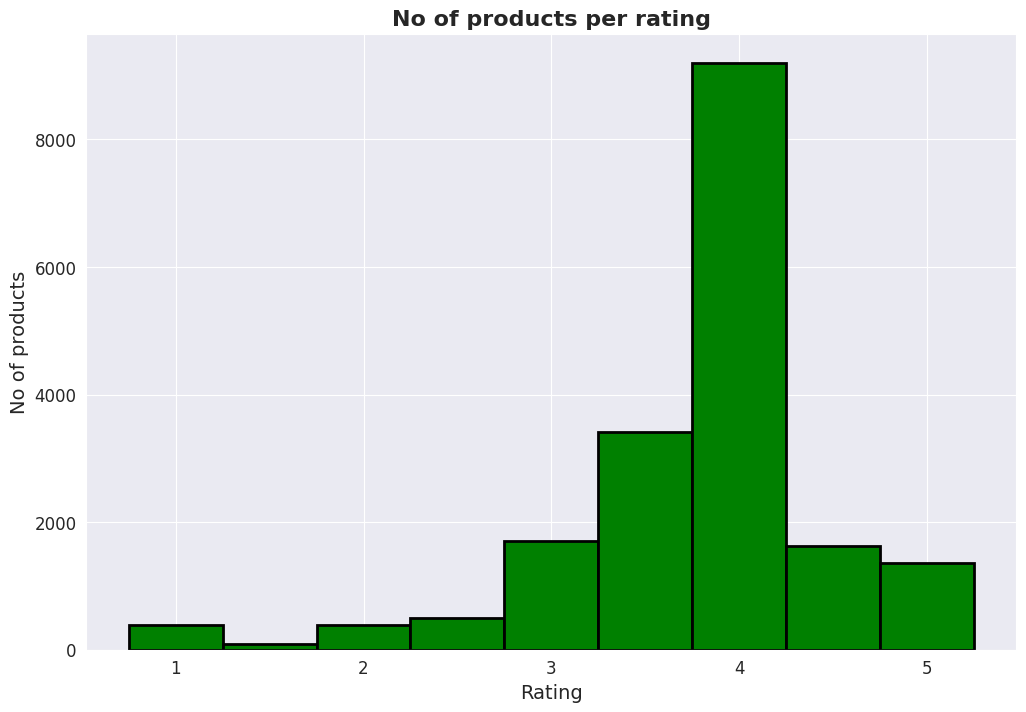

In [ ]:
#No of Products per rating
plt.figure(figsize=(12,8))
axi=plt.hist(df.rating,bins=np.arange(1,6,0.5),edgecolor="black",align='left',linewidth=2,color="green")
plt.xlabel("Rating",fontsize=14)
plt.ylabel("No of products",fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("No of products per rating",fontsize=16,fontweight='bold')
plt.show()

In [18]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['description'])
tfidf_matrix.shape

(18650, 23342)

In [19]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim

array([[1.        , 0.016307  , 0.01003499, ..., 0.01060276, 0.01131929,
        0.        ],
       [0.016307  , 1.        , 0.00720632, ..., 0.        , 0.        ,
        0.        ],
       [0.01003499, 0.00720632, 1.        , ..., 0.0063872 , 0.        ,
        0.        ],
       ...,
       [0.01060276, 0.        , 0.0063872 , ..., 1.        , 0.        ,
        0.        ],
       [0.01131929, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [26]:
def get_recommendations(product):
    prod_titles = df['product'].values
    if product not in prod_titles:
        df1 = pd.DataFrame(['Product Not Recognized.'], columns=[''])
        return df1

    similarities = cosine_sim
    prod_indx= np.where(prod_titles == product)[0]
    similarity_scores= similarities[prod_indx].ravel()
    titles_vs_scores= dict(zip(prod_titles, similarity_scores))
    top_5_similar= sorted(titles_vs_scores.items(), key= lambda x: x[1], reverse= True)[1:6]


    titles = []
    ratings = []
    for i, (name, score) in enumerate(top_5_similar):
      titles.append(name)
      rating = df.loc[df['product'] == name, 'rating'].iloc[0]
      ratings.append(rating)

    data = {'Title': titles,'Rating': ratings}
    df2 = pd.DataFrame(data)

    return df2

In [27]:
get_recommendations('Water Bottle - Orange')

,Title,Rating
0,"Rectangular Plastic Container - With Lid, Mult...",3.0
1,"Jar - With Lid, Yellow",3.7
2,"Round & Flat Storage Container - With lid, Green",4.6
3,Premium Rectangular Plastic Container With Lid...,3.6
4,Premium Round Plastic Container With Lid - Pink,3.6


In [28]:
get_recommendations('Cadbury Perk - Chocolate Bar')

,Title,Rating
0,Cadbury Perk - Chocolate Bar,4.2
1,Choco Stick - Hexagon Pack,4.4
2,Luvit Chocwich White Home Delights 187 g,4.1
3,Luvit Chocwich Home Delights 187 g,3.9
4,Wafer Biscuits - Chocolate Flavor,4.2
